In [1]:
from pepnets.PeptideNetwork import PeptideNetwork
import random
import pandas as pd
import numpy as np


random.seed(42)
np.random.seed(42)

sus_scrofa = pd.read_csv("../data/sus_scrofa.gz", sep="\t")
sus_scrofa["Entry Name"] = sus_scrofa["Entry Name"].apply(lambda x: x.split("_")[0])
datamatrix = pd.read_csv("../data/data.csv")
is_multi = datamatrix["Protein"].value_counts() > 3 # we cannot build communities with less than 3 peptides
datamatrix = datamatrix[datamatrix["Protein"].isin(is_multi[is_multi].index)]
pnet = PeptideNetwork(
    datamatrix=datamatrix,
    protein_database=sus_scrofa,
)

Reading peptides...


In [2]:
pnet.create_network(distance_cutoff=4)

{'ICAL': <networkx.classes.graph.Graph at 0x10901d130>,
 'OLR1': <networkx.classes.graph.Graph at 0x10901d310>,
 'VTNC': <networkx.classes.graph.Graph at 0x10901d8e0>,
 'ITIH2': <networkx.classes.graph.Graph at 0x10901ddf0>,
 'ANXA1': <networkx.classes.graph.Graph at 0x10901dd60>,
 'TPM3': <networkx.classes.graph.Graph at 0x10901d5b0>,
 'VIME': <networkx.classes.graph.Graph at 0x108ead160>,
 'LOX15': <networkx.classes.graph.Graph at 0x108ead220>,
 'SAA4': <networkx.classes.graph.Graph at 0x108ead280>,
 'ACTS': <networkx.classes.graph.Graph at 0x10901e070>,
 'UPTI': <networkx.classes.graph.Graph at 0x108e3abb0>,
 'COF1': <networkx.classes.graph.Graph at 0x10901e160>,
 'CXCL7': <networkx.classes.graph.Graph at 0x10901e190>,
 'WT1': <networkx.classes.graph.Graph at 0x10901e100>,
 'CLUS': <networkx.classes.graph.Graph at 0x108ead370>,
 'HBA': <networkx.classes.graph.Graph at 0x10901da90>,
 'CAP7': <networkx.classes.graph.Graph at 0x108ead2b0>,
 'PRDX6': <networkx.classes.graph.Graph at 0x1

In [3]:
clusters = pnet.get_clusters(resolution=0.8)
clusters.merge_nearby_clusters(wiggle_room=2)
clusters.remove_small_clusters(threshold=3)
clusters.reindex()


Merged 39 clusters

Removed 0 clusters
Removed 848 clusters
Removed 279 clusters


<Figure size 640x480 with 0 Axes>

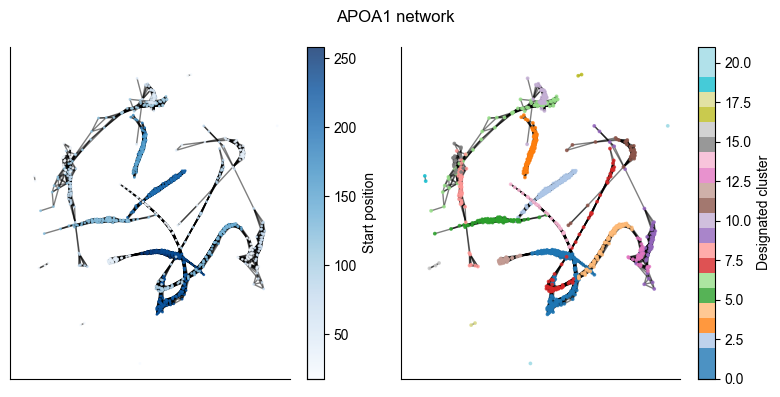

In [4]:
pnet.plot_protein("APOA1", save_str="../plots/APOA1.png")

In [5]:
pnet.clusters.reindex()

In [6]:
from pepnets.FeatureMatrix import FeatureMatrix

fm = FeatureMatrix(datamatrix, clusters)
fm.datamatrix.to_csv("../data/processed_datamatrix.csv", index=False)

Dropped:  1487


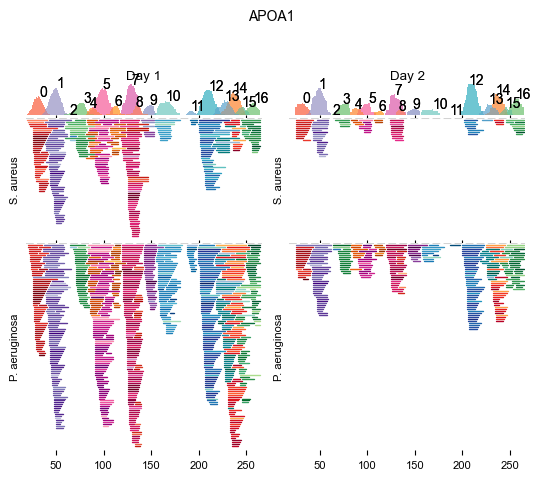

In [7]:
from pepnets.PeptiGrams import PeptiGram

design = pd.read_csv("../data/design.csv")
peptigram = PeptiGram(fm.datamatrix, design)
peptigram.plot_peptigram(
    "APOA1", groups=["S. aureus", "P. aeruginosa"], days=["Day 1", "Day 2"], size_factor=0.5,
    save_str="../plots/APOA1_pg.png"
)


In [8]:
topn = fm.get_topn()
topn.head(3)

,Sample 17 Day 1,Sample 18 Day 1,Sample 19 Day 1,Sample 20 Day 1,Sample 21 Day 1,Sample 22 Day 1,Sample 23 Day 1,Sample 24 Day 1,Sample 25 Day 1,Sample 26 Day 1,...,Sample 56 Day 3,Sample 57 Day 3,Sample 6 Day 1,Sample 7 Day 1,Sample 8 Day 1,Sample 9 Day 1,Sample 6 Day 2,Sample 7 Day 2,Sample 8 Day 2,Sample 9 Day 2
F1RX36_2,56.674605,56.385190,57.790651,60.037055,60.628009,60.390650,58.567739,60.580368,60.523998,59.960927,...,61.628429,61.541113,60.193319,57.933486,58.896834,55.940041,59.055682,59.879967,56.774901,53.716728
F1RX36_10,41.156538,36.808606,40.615099,37.461259,38.702363,41.088525,40.718204,35.638778,41.107344,36.707923,...,45.994196,46.233593,38.806222,40.492710,43.687794,36.538940,42.259950,39.406260,36.996664,3.974760
F1RX36_32,44.589290,48.515610,47.193364,46.128803,48.106766,46.631531,46.789575,40.252548,48.753892,40.889646,...,41.100286,41.238735,44.843393,48.460596,49.415482,42.134835,39.399840,38.351522,38.090766,38.519241


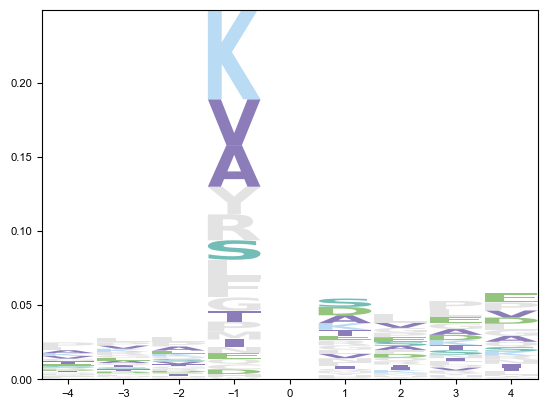

In [9]:
from pepnets.LogoPlot import LogoPlot

datamatrix = pd.read_csv("../data/data.csv")
sus_scrofa = pd.read_csv("../data/sus_scrofa.gz", sep="\t")
proteins = [p + "_PIG" for p in datamatrix["Protein"].unique()]
sus_scrofa = sus_scrofa[sus_scrofa["Entry Name"].isin(proteins)]


test_samples = design[design["group"] == "P. aeruginosa"]["sample"].tolist()
background_samples = design[design["group"] == "Ctrl"]["sample"].tolist()


lp = LogoPlot(fm.datamatrix, design, sus_scrofa, topn)
import matplotlib.pyplot as plt
height = lp.get_letter_heights(test_samples, background_samples)
fig, ax = plt.subplots(1,1)
lp.plot(height, ax=ax)
plt.savefig("../plots/logo.png", bbox_inches="tight")